#Libraries, Dates and Data

In [ ]:
#installing libraries
!pip install yfinance
!pip install tfcausalimpact

In [6]:
#import libraries
import yfinance as yf
import pandas as pd
from causalimpact import CausalImpact 
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
#Dates
training_start = "2014-01-08"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-02"

In [34]:
#Download VW stock
y = ["VOW.DE"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1wk")
y = y['Adj Close'].rename("y")
y.head(1)

[*********************100%***********************]  1 of 1 completed


Date
2014-01-06    159.312714
Name: y, dtype: float64

In [35]:
#Dowload the control groups
stocks = ["META", "DIS", "NVS", "AMZ"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1wk")
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()

[*********************100%***********************]  4 of 4 completed


,AMZ,DIS,META,NVS
Date,,,,
2014-01-06,290.200012,69.382637,57.939999,52.987686
2014-01-13,296.000000,68.084991,56.299999,52.883461
2014-01-20,287.000000,66.925392,54.450001,52.010544
2014-01-27,271.299988,66.824165,62.570000,51.508930
2014-02-03,260.450012,69.640320,64.320000,52.714088


In [25]:
#Combine everything
X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,AMZ,DIS,META,NVS
Date,,,,,
2014-01-06,159.312729,290.200012,69.382629,57.939999,52.987690
2014-01-13,161.315369,296.000000,68.084999,56.299999,52.883450
2014-01-20,151.220398,287.000000,66.925385,54.450001,52.010536
2014-01-27,147.419449,271.299988,66.824158,62.570000,51.508930
2014-02-03,149.176865,260.450012,69.640327,64.320000,52.714088


#Correlation Matrix

In [26]:
#Subset the training data
df_training = df[df.index <= training_end]
df_training.tail()

,y,AMZ,DIS,META,NVS
Date,,,,,
2015-07-13,172.998123,445.350006,111.423409,94.970001,73.266487
2015-07-27,157.080902,484.250000,112.492088,94.010002,71.840057
2015-08-10,153.624374,478.299988,100.455429,94.419998,70.960663
2015-08-17,140.822342,445.049988,92.655968,86.059998,67.553886
2015-08-24,145.516418,465.399994,96.068245,91.010002,68.100914


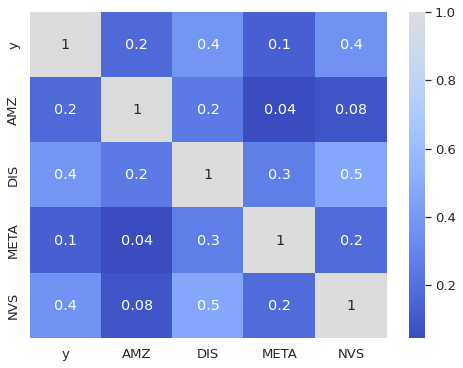

In [27]:
#Heatmap
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = True)

In [28]:
#Preparing final df
df_final = df.drop(columns = ["META", "AMZ"])
df_final.head(0)

,y,DIS,NVS
Date,,,


#Google Causal Impact

In [40]:
#Get first and last date
print(df_final.head(1))
print(df_final.tail(10))

                     y        DIS       NVS
Date                                       
2014-01-06  159.312729  69.382629  52.98769
                     y         DIS        NVS
Date                                         
2015-07-13  172.998123  111.423409  73.266487
2015-07-27  157.080902  112.492088  71.840057
2015-08-10  153.624374  100.455429  70.960663
2015-08-17  140.822342   92.655968  67.553886
2015-08-24  145.516418   96.068245  68.100914
2015-08-31  136.512329   94.652702  65.469666
2015-09-07  141.889191   97.943115  66.854530
2015-09-14  137.707184   96.405701  66.923767
2015-09-21   98.618317   94.024635  63.226173
2015-09-28   86.328354   96.555695  64.583344


In [43]:
#Dates
training_start = "2014-01-06"
training_end = "2015-08-31"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-02"

In [44]:
#Define Pre and Post Period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

In [45]:
#CI
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


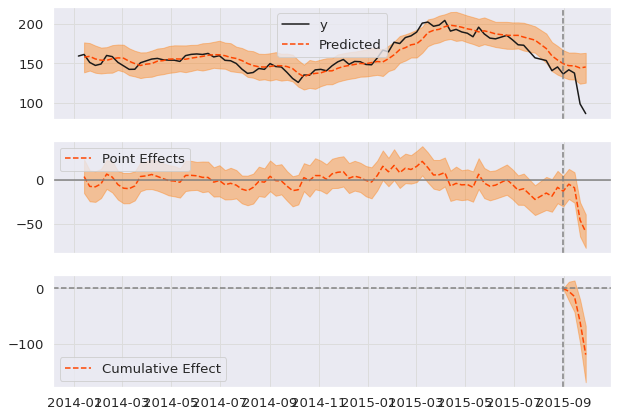

In [46]:
#Output
impact.plot()

In [47]:
#summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    116.14             464.54
Prediction (s.d.)         145.91 (6.53)      583.64 (26.11)
95% CI                    [133.12, 158.7]    [532.46, 634.8]

Absolute effect (s.d.)    -29.77 (6.53)      -119.1 (26.11)
95% CI                    [-42.56, -16.98]   [-170.26, -67.92]

Relative effect (s.d.)    -20.41% (4.47%)    -20.41% (4.47%)
95% CI                    [-29.17%, -11.64%] [-29.17%, -11.64%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
